### Configuration and imports

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

### Data import

In [2]:
dir_path= './data'
data_path = os.path.join(dir_path, 'diabetes_simple.csv')

df = pd.read_csv(data_path)

df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49510 entries, 0 to 49509
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   gender               49510 non-null  object 
 1   age                  49510 non-null  float64
 2   hypertension         49510 non-null  int64  
 3   heart_disease        49510 non-null  int64  
 4   smoking_history      49510 non-null  object 
 5   bmi                  49510 non-null  float64
 6   HbA1c_level          49510 non-null  float64
 7   blood_glucose_level  49510 non-null  int64  
 8   diabetes             49510 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 3.4+ MB


In [4]:
df.shape

(49510, 9)

In [5]:
columns = df.columns.tolist()
target_column = 'diabetes'

columns

['gender',
 'age',
 'hypertension',
 'heart_disease',
 'smoking_history',
 'bmi',
 'HbA1c_level',
 'blood_glucose_level',
 'diabetes']

### Creating pipelines for model classification

In [6]:
measures = ['accuracy', 'f1', 'precision', 'recall']

In [7]:
ordered_smoking_labels = ['No info', 'never', 'former', 'not current', 'current', 'ever']

In [8]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.svm import SVC

import matplotlib.pyplot as plt
from diabetes_model_creation import create_data_pipelines, separate_data, encoding_data, grid_search_pipe, get_measures_values, save_measures
import joblib


cols_to_encode = ['gender', 'smoking_history']
numerical_cols = df.select_dtypes(exclude=['object']).columns.tolist()

if target_column in numerical_cols:
    numerical_cols.remove(target_column)

In [9]:
# data pipeline creation
preprocessor = create_data_pipelines(numerical_cols, cols_to_encode)


In [10]:
x_train, x_test, y_train, y_test = separate_data(df, target_column)

y_train, y_test = encoding_data(y_train, y_test)

#### Grid Search in all models

In [11]:
# creating dict with models

# to test MLP, SVC and AdaBoosting
clf_dicts = [ { 
                    'model_name':  'Decision Tree',
                    'saving_name':  'dt_clf',
                    'model_base':  DecisionTreeClassifier(random_state=0),
                    'best_model': None
                  },
              {
                    'model_name':  'Gradient Boosting',
                    'saving_name':  'gbm_clf',
                    'model_base':  GradientBoostingClassifier(random_state=0),
                    'best_model': None
                  },
                {
                    'model_name':  'Hist Gradient Boosting',
                    'saving_name':  'hgbm_clf',
                    'model_base':  HistGradientBoostingClassifier(random_state=42),
                    'best_model': None
                  },
                {
                    'model_name':  'Random Forest',
                    'saving_name':  'rf_clf',
                    'model_base':  RandomForestClassifier(random_state=0),
                    'best_model': None
                  },
                {
                    'model_name':  'SVC',
                    'saving_name':  'svc_clf',
                    'model_base':  SVC(random_state=42),
                    'best_model': None
                  },
                ]

In [13]:
fig, ax = plt.subplots()
for est in clf_dicts:
  
  name = est['model_name']
  save = est['saving_name']
  model = est['model_base']
  cod = est['saving_name']

  print(f'Grid Search on {name} classifier')

  best = grid_search_pipe(model, name, x_train, y_train, preprocessor, measures)
  

  # print the best model and its hyperparameters
  print(f'best {name}: {best.get_params()}')

  # fit the best model on the training data
  best.fit(x_train, y_train)

  # make predictions on the testing data
  pred = best.predict(x_test)

  est['best_model'] = best

  acc_, recall_, f1, precision = get_measures_values(y_test, pred)

    # print the performance measures
  print(f'Accuracy score: {acc_:.2%}')
  print(f'Recall score: {recall_:.2%}')
  print(f'F1-score: {f1:.2%}')
  print(f'Precision score: {precision:.2%}')


  # plot precision-recall curve
  PrecisionRecallDisplay.from_predictions(y_test, pred, name=name, ax=ax)

  # Save measures
  save_measures(acc_, recall_, f1, precision, cod)

  # Set directory path
  model_folder = 'models'
  if not os.path.exists(model_folder):
    os.mkdir(model_folder)

  # Save pipeline  
  joblib.dump(best, os.path.join(model_folder, f'{save}_pipeline.pkl'))


results_dir = 'results'
if not os.path.exists(results_dir):
    os.mkdir(results_dir)

plt.title('Precision Recall curve of classifiers')
plt.savefig(os.path.join(results_dir, 'precision_recall_curve_clfs.png'), dpi=300)
plt.show()

### Visualizing results

In [16]:

scores = pd.read_csv(os.path.join(results_dir, 'scores.csv'), index_col=0)

scores

,Accuracy,Recall,f1-score,Precision
Model names,,,,
dt_clf,0.970108,0.682407,0.799349,0.964660
gbm_clf,0.970351,0.680556,0.800218,0.970938
hgbm_clf,0.970351,0.682407,0.800652,0.968463
rf_clf,0.969866,0.677778,0.796952,0.966975
svc_clf,0.961141,0.607407,0.731735,0.920056


#### Visualizing classification metrics performances

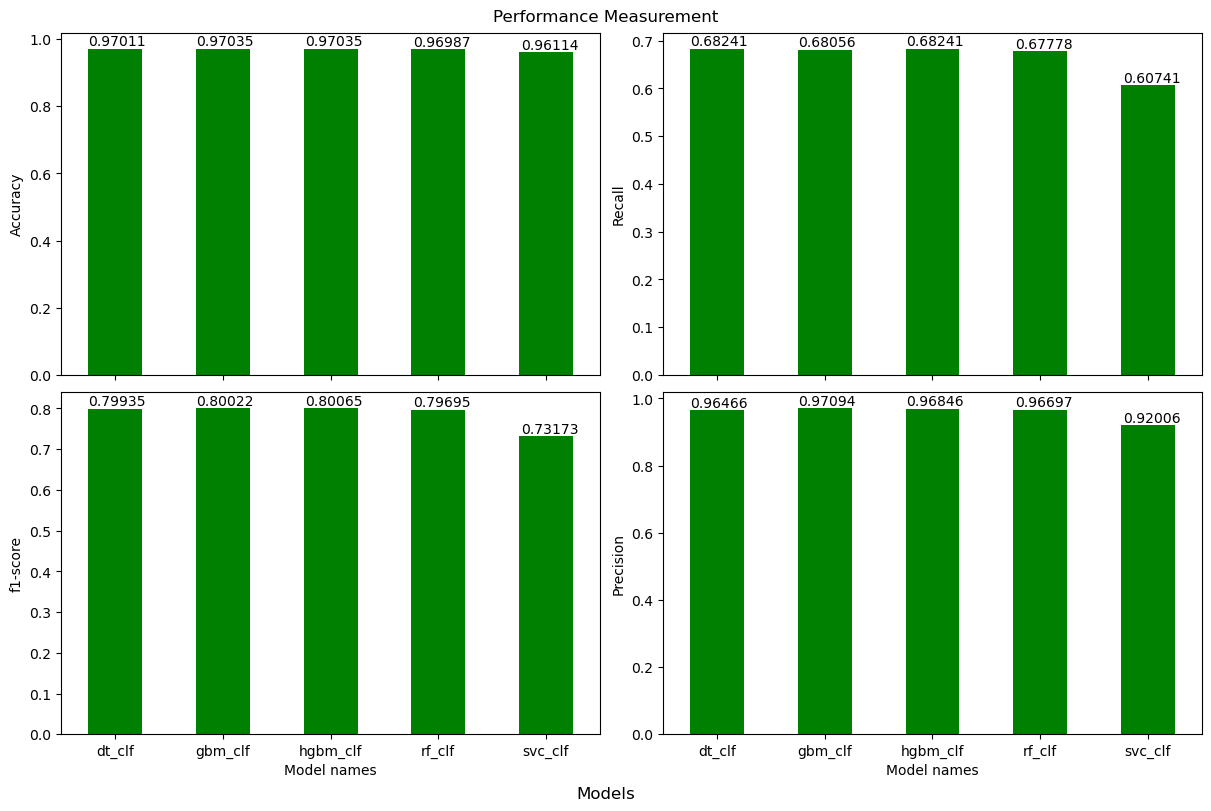

In [17]:
rows = 2
cols = 2
fig, ax = plt.subplots(rows, cols, sharex=True, constrained_layout=True, figsize=(12, 8))
m = 0
measures_cols = scores.columns.tolist()
for r in range(rows):
    for c in range(cols):
        scores[measures_cols[m]].plot.bar(rot=0, color='green', ax=ax[r, c])

        ax[r, c].set_ylabel(measures_cols[m])

        for pat in ax[r, c].patches:
            ax[r, c].annotate(f'{pat.get_height():.5f}', (pat.get_x() * 1.005, pat.get_height() * 1.01))
        
        m += 1
        
plt.suptitle('Performance Measurement')
fig.supxlabel('Models')
plt.savefig(os.path.join(results_dir, 'performance_models.png'), dpi=300)
plt.show()

The best model was Hist Gradient Boosting, almost tied with Gradient Boosting!


### Feature Importance on the best model

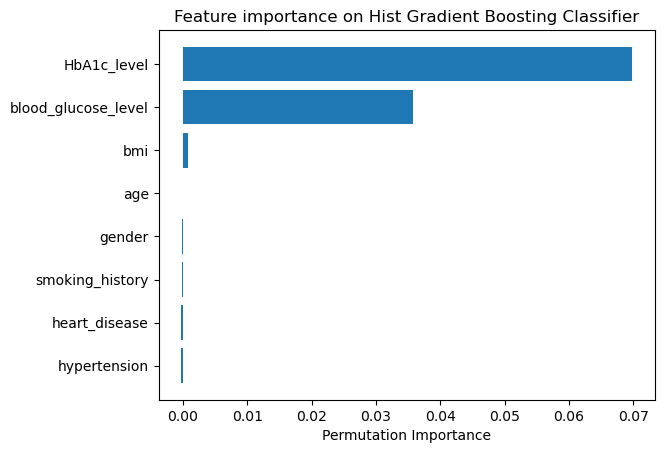

In [18]:
from sklearn.inspection import permutation_importance

hgbm_clf_pipeline = joblib.load(os.path.join(model_folder, f'hgbm_clf_pipeline.pkl'))

perm_importance = permutation_importance(hgbm_clf_pipeline, x_test, y_test)

feature_names = x_train.columns.tolist()
features = np.array(feature_names)

sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.title('Feature importance on Hist Gradient Boosting Classifier')

plt.savefig(os.path.join(results_dir, 'feature_importance_hgbm.png'), dpi=300)
plt.show()